In [9]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc




In [10]:
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)



In [11]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import dok_matrix, csc_matrix
from joblib import Parallel, delayed

def angular_and_bifurcation_checks(i, vectors, norms, segments, N, alpha, eps):
    """Performs angular consistency and bifurcation checks for a given index `i`."""
    results_ang = []
    results_bif = []
    
    vect_i = vectors[i]
    norm_i = norms[i]

    for j in range(i + 1, N):  # Only upper triangle
        vect_j = vectors[j]
        norm_j = norms[j]
        cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

        # Angular consistency
        if np.abs(cosine - 1) < eps:
            results_ang.append((i, j, 1))

        # Bifurcation consistency
        seg_i, seg_j = segments[i], segments[j]
        if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
            results_bif.append((i, j, -alpha))
        elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
            results_bif.append((i, j, -alpha))

    return results_ang, results_bif

def generate_hamiltonian_optimizedPAR(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    eps = 1e-9  # Precision threshold

    # Perform angular and bifurcation checks in parallel
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(angular_and_bifurcation_checks)(i, vectors, norms, segments, N, alpha, eps)
        for i in range(N)
    )

    # Aggregate results
    A_ang = dok_matrix((N, N), dtype=np.float64)
    A_bif = dok_matrix((N, N), dtype=np.float64)

    for ang_results, bif_results in results:
        for i, j, value in ang_results:
            A_ang[i, j] = value
            A_ang[j, i] = value  # Symmetric
        for i, j, value in bif_results:
            A_bif[i, j] = value
            A_bif[j, i] = value  # Symmetric

    # Convert angular and bifurcation matrices to sparse format
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)
    true_solution = np.array([1 if segment.truth else 0 for segment in segments])



    return A, b, true_solution


In [5]:
def qubosolverQA(A, b):
    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-4d20b60b0faf5516868e16417928459ad087bd50'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    print(f"Solution: {sol_sample}")

    return sol_sample


In [12]:
from dwave.system import LeapHybridSampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-4d20b60b0faf5516868e16417928459ad087bd50'
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix
from dimod import BinaryQuadraticModel

def qubosolverHr(A, b):
   
    # Keep A sparse
    A = csc_matrix(A)
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    # Add the linear terms from vector b
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  # Only consider off-diagonal terms (interactions)
            bqm.add_interaction(i, j, A[i, j])

    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)


    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    return sol_sample
#qubosolverHr(A, b)

In [13]:
def qubosolverSA(A, b):
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  


    print(f"Solution:{sol_sample}")


    return sol_sample

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.spatial.distance import hamming
from scipy.sparse import csc_matrix

import numpy as np

def calculate_accuracy_metrics(true_solution, solver_solution):
    true_solution = np.array(true_solution)
    solver_solution = np.array(solver_solution)
    
    #total `1`s in true_solution
    N_gen_hit = np.sum(true_solution == 1)
    
    #number of `1`s in solver_solution that match `1`s in true_solution)
    N_correct_hit = np.sum((true_solution == 1) & (solver_solution == 1))
    
    # Hit-efficiency (e_eff): Fraction of true hits that are correctly identified in solver_solution
    e_eff = N_correct_hit / N_gen_hit if N_gen_hit > 0 else 0

    N_all_track = np.sum(solver_solution == 1)
    N_fake_track = N_all_track - N_correct_hit
    
    #fraction of found tracks that are not associated with a true hit
    f_fake = N_fake_track / N_all_track if N_all_track > 0 else 0
    
    #Fraction of hits in solver_solution that are correctly assigned
    e_pure = N_correct_hit / N_all_track if N_all_track > 0 else 0
    
    return e_eff, f_fake, e_pure

def compare_qubo_solvers(N_PARTICLES_LIST, params):
    results = []
    
    # Initialize flags to track which solvers should continue
    qubosolverSA_active = True
    qubosolverHr_active = True
    qubosolverQA_active = False
    
    for N_PARTICLES in N_PARTICLES_LIST:
        try:
            # Generate event and matrix
            event = generator.generate_event(N_PARTICLES)
            A, b, true_solution = generate_hamiltonian_optimizedPAR(event, params)
            A = csc_matrix(A)
            b = np.array(b, dtype=np.int8)
        
            # Only attempt qubosolverSA if it hasn't encountered an error previously
            if qubosolverSA_active:
                try:
                    sol1 = np.array(qubosolverSA(A, b), dtype=np.int8)
                    accuracy_1 = calculate_accuracy_metrics(true_solution, sol1)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverSA", 
                                    "Hit Efficiency": accuracy_1[0],
                                    "Fake Rates": accuracy_1[1], 
                                    "Hit Purity": accuracy_1[2]})
                except Exception as e:
                    print(f"Error with qubosolverSA for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverSA_active = False  # Deactivate further testing of qubosolverSA
            
            # Only attempt qubosolverHr if it hasn't encountered an error previously
            if qubosolverHr_active:
                try:
                    sol2 = np.array(qubosolverHr(A, b), dtype=np.int8)
                    accuracy_2 = calculate_accuracy_metrics(true_solution, sol2)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverHr", 
                                    "Hit Efficiency": accuracy_2[0],
                                    "Fake Rates": accuracy_2[1], 
                                    "Hit Purity": accuracy_2[2]})
                except Exception as e:
                    print(f"Error with qubosolverHr for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverHr_active = False  # Deactivate further testing of qubosolverHr
                
            # Only attempt qubosolverQA if it hasn't encountered an error previously
            if qubosolverQA_active:
                try:
                    sol3 = np.array(qubosolverQA(A, b), dtype=np.int8)
                    accuracy_3 = calculate_accuracy_metrics(true_solution, sol3)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverQA", 
                                    "Hit Efficiency": accuracy_3[0],
                                    "Fake Rates": accuracy_3[1], 
                                    "Hit Purity": accuracy_3[2]})
                except Exception as e:
                    print(f"Error with qubosolverQA for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverQA_active = False  # Deactivate further testing of qubosolverQA
        
        except MemoryError as mem_err:
            print(f"MemoryError encountered for N_PARTICLES={N_PARTICLES}: {mem_err}")
            continue
        
        except Exception as e:
            print(f"An error occurred while preparing for N_PARTICLES={N_PARTICLES}: {e}")
            continue

    results_df = pd.DataFrame(results)
    results_df.to_csv("qubo_solver_results80scakingFINAL.csv", index=False)
    return results_df


# Parameters and Particle List
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}
N_PARTICLES_LIST = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
#N_PARTICLES_LIST = [2,4,6,8,10,12,14,16,18,20]

# Run the comparison function and save the results
results_df = compare_qubo_solvers(N_PARTICLES_LIST, params)
results_df.to_csv("qubossolutioncomparisment.csv", index=False)


Solution:[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 

KeyboardInterrupt: 

In [ ]:
#data for 80 particles 5 layers, QA< SA AND HYBRID

import pandas as pd

# Load the previously saved CSV file
results_df = pd.read_csv("qubos80particleSOLUTIONSTESTING.csv")

latex_table = results_df.to_latex(index=False, float_format="%.2f", 
                                    caption="Comparison of QUBO Solvers on Particle Tracks",
                                    label="tab:qubo_solver_results")

# Save LaTeX table to file
with open("qubo_solver_results.tex", "w") as file:
    file.write(latex_table)



 N_PARTICLES       Solver  Percentage_Similarity  Hamming_Distance  Simple_Matching_Coefficient
           2 qubosolverSA              100.00000                 0                      1.00000
           2 qubosolverHr              100.00000                 0                      1.00000
           2 qubosolverQA              100.00000                 0                      1.00000
           4 qubosolverSA              100.00000                 0                      1.00000
           4 qubosolverHr              100.00000                 0                      1.00000
           4 qubosolverQA              100.00000                 0                      1.00000
           6 qubosolverSA              100.00000                 0                      1.00000
           6 qubosolverHr              100.00000                 0                      1.00000
           6 qubosolverQA               98.61110                 1                      0.98610
           8 qubosolverSA              1

In [3]:
import pandas as pd
import numpy as np

# Define the data with inconsistent lengths
data = {
    "N_PARTICLES": [2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 14, 14, 16, 16, 18, 18, 20, 20],
    "Solver": ["qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr"],
    "Hit Efficiency": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6875, 1.0, 1.0, 0.475, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    "Fake Rate": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2143, 0.0, 0.0, 0.3667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    "Hit Purity": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7857, 1.0, 1.0, 0.6333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
}

# Find the maximum length of the data arrays
max_length = max(len(column) for column in data.values())

# Pad all columns to the same length
for key in data.keys():
    if len(data[key]) < max_length:
        data[key].extend([np.nan] * (max_length - len(data[key])))

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)

    N_PARTICLES        Solver  Hit Efficiency  Fake Rate  Hit Purity
0             2  qubosolverSA          1.0000     0.0000      1.0000
1             2  qubosolverHr          1.0000     0.0000      1.0000
2             2  qubosolverQA          1.0000     0.0000      1.0000
3             4  qubosolverSA          1.0000     0.0000      1.0000
4             4  qubosolverHr          1.0000     0.0000      1.0000
5             4  qubosolverQA          1.0000     0.0000      1.0000
6             6  qubosolverSA          1.0000     0.0000      1.0000
7             6  qubosolverHr          1.0000     0.0000      1.0000
8             6  qubosolverQA          1.0000     0.0000      1.0000
9             8  qubosolverSA          1.0000     0.0000      1.0000
10            8  qubosolverHr          1.0000     0.0000      1.0000
11            8  qubosolverQA          0.6875     0.2143      0.7857
12           10  qubosolverSA          1.0000     0.0000      1.0000
13           10  qubosolverHr     

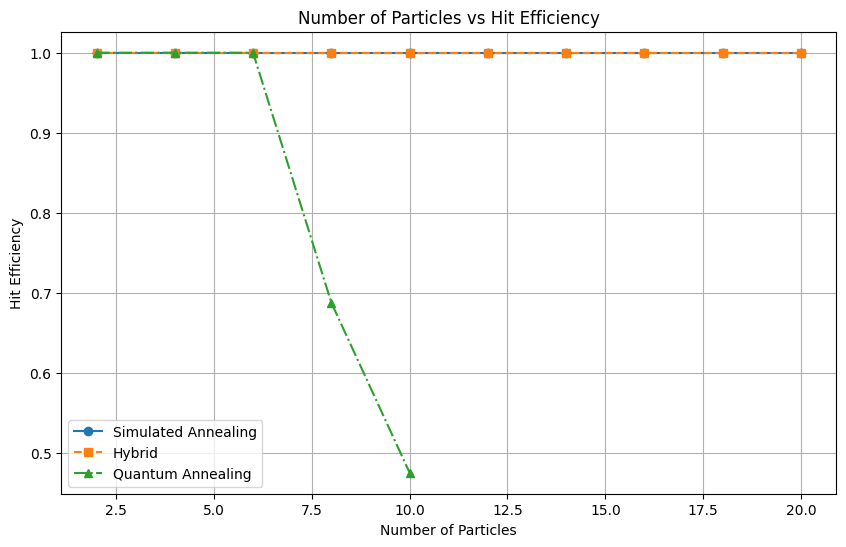

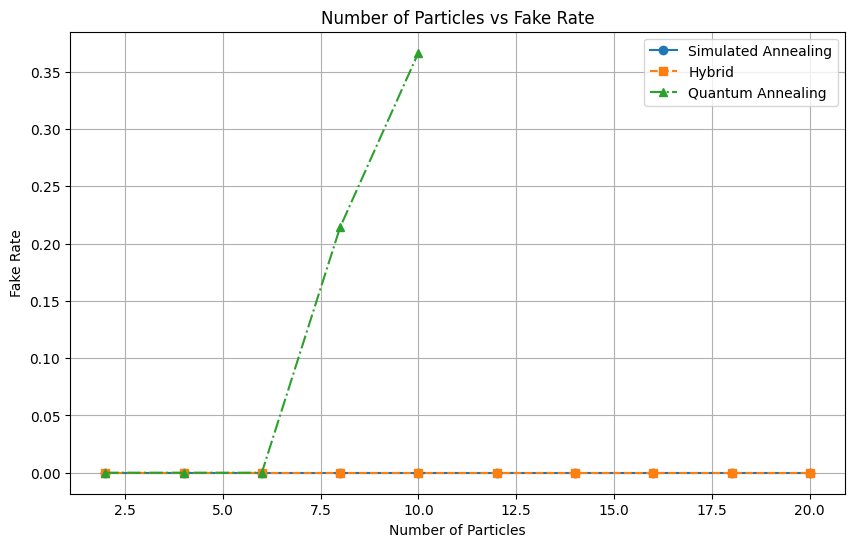

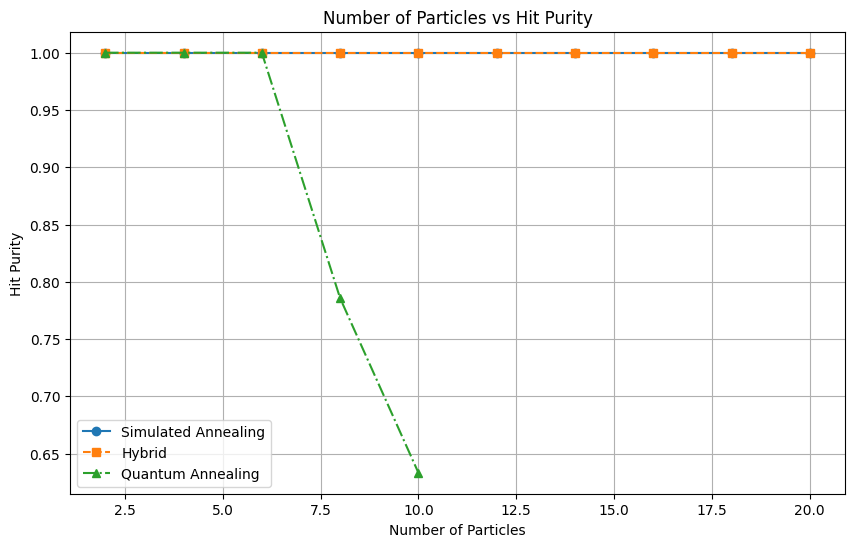

In [6]:
import matplotlib.pyplot as plt

# Plot function for Hit Efficiency, Fake Rate, and Hit Purity
def plot_results(results_df):
    # Solver name mappings
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    
    solvers = results_df['Solver'].unique()  # Get unique solvers
    
    # Define styles
    linestyles = ['-', '--', '-.', ':']  # Different line styles
    markers = ['o', 's', '^', 'D']       # Different markers
    
    # Ensure there are enough styles for all solvers
    styles = zip(linestyles * (len(solvers) // len(linestyles) + 1), 
                 markers * (len(solvers) // len(markers) + 1))
    
    style_map = {solver: style for solver, style in zip(solvers, styles)}
    
    # Plot 1: Number of Particles vs Hit Efficiency
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Hit Efficiency'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Hit Efficiency")
    plt.xlabel("Number of Particles")
    plt.ylabel("Hit Efficiency")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 2: Number of Particles vs Fake Rate
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Fake Rate'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Fake Rate")
    plt.xlabel("Number of Particles")
    plt.ylabel("Fake Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 3: Number of Particles vs Hit Purity
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Hit Purity'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Hit Purity")
    plt.xlabel("Number of Particles")
    plt.ylabel("Hit Purity")
    plt.legend()
    plt.grid(True)
    plt.show()


# Generate the plots
plot_results(results_df)

In [ ]:
from itertools import product
from scipy.sparse import csc_matrix

def brute_force(A, b):
    A = csc_matrix(A)
    n = len(b) 

    best_solution = None
    best_energy = np.inf
    for config in product([0, 1], repeat=n):
        config = np.array(config)
        
        #calculate energy: E = x^T A x + b^T x
        energy = config @ A @ config + b @ config
        if energy < best_energy:
            best_energy = energy
            best_solution = config

    print(f"Best Solution: {best_solution}")
    print(f"Best Energy: {best_energy}")

    return best_solution


brute_force_solution = brute_force(A, b)
print(f"Brute Force Solution: {brute_force_solution}")




Best Solution: [1 0 0 1 1 0 0 1]
Best Energy: -4.0
Brute Force Solution: [1 0 0 1 1 0 0 1]
